In [1]:
import os
import shutil
import unittest
from catvae.trainer import LightningCatVAE
from catvae.sim import multinomial_bioms
from biom import Table
from biom.util import biom_open
import numpy as np
from pytorch_lightning import Trainer
import torch
import argparse
import seaborn as sns

In [2]:
import torch
torch.__version__

'1.7.0.dev20200905'

# Simulate data

In [43]:
np.random.seed(0)
k = 10
sims = multinomial_bioms(k=k, D=100, N=1000, M=100)
Y = sims['Y']
parts = Y.shape[0] // 10
samp_ids = list(map(str, range(Y.shape[0])))
obs_ids = list(map(str, range(Y.shape[1])))
train = Table(Y[:parts * 8].T, obs_ids, samp_ids[:parts * 8])
test = Table(Y[parts * 8 : parts * 9].T,
             obs_ids, samp_ids[parts * 8 : parts * 9])
valid = Table(Y[parts * 9:].T, obs_ids, samp_ids[parts * 9:])
tree = sims
with biom_open('train.biom', 'w') as f:
    train.to_hdf5(f, 'train')
with biom_open('test.biom', 'w') as f:
    test.to_hdf5(f, 'test')
with biom_open('valid.biom', 'w') as f:
    valid.to_hdf5(f, 'valid')

In [44]:
sims['tree'].write('basis.nwk')

'basis.nwk'

In [45]:
train

100 x 800 <class 'biom.table.Table'> with 46247 nonzero entries (57% dense)

# Train model

In [46]:
output_dir = 'output'
args = [
    '--train-biom', 'train.biom',
    '--test-biom', 'test.biom',
    '--val-biom', 'valid.biom',
    '--basis', 'basis.nwk',
    '--output-directory', output_dir,
    '--epochs', '20',
    '--batch-size', '50',
    '--steps-per-batch', '20',
    '--num-workers', '20',
    '--scheduler', 'steplr',
    '--learning-rate', '1e-3',
    '--imputer', 'lda',
    '--n-latent', str(k),
    '--gpus', '1'
]
parser = argparse.ArgumentParser(add_help=False)
parser = LightningCatVAE.add_model_specific_args(parser)
parser.add_argument('--num-workers', type=int)
parser.add_argument('--gpus', type=int)
args = parser.parse_args(args)
model = LightningCatVAE(args)
model.set_eigs(sims['eigvectors'], sims['eigs'])

trainer = Trainer(
    max_epochs=args.epochs,
    gpus=args.gpus,
    check_val_every_n_epoch=1,
    # profiler=profiler,
    fast_dev_run=False,
    # auto_scale_batch_size='power'
)
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
/home/juermieboop/miniconda3/envs/catvae/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name  | Type         | Params
---------------------------------------
0 | model | LinearCatVAE | 6 K   


Saving latest checkpoint..


1

In [6]:
%load_ext tensorboard

In [7]:
%tensorboard --logdir lightning_logs

Reusing TensorBoard on port 6006 (pid 30075), started 0:25:17 ago. (Use '!kill 30075' to kill it.)

In [8]:
trainer.model

LightningCatVAE(
  (model): LinearCatVAE(
    (encoder): Linear(in_features=99, out_features=10, bias=False)
    (decoder): Linear(in_features=10, out_features=99, bias=False)
  )
)

# Evaluate the model

In [53]:
!ls lightning_logs/version_28/checkpoints

'epoch=14.ckpt'


In [48]:
torch.__version__

'1.7.0.dev20200905'

In [54]:
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
checkpoint_dir = 'lightning_logs/version_28/checkpoints'
path = f'{checkpoint_dir}/epoch=14.ckpt'
model = LightningCatVAE.load_from_checkpoint(path).cuda()

(0.6763679087176441, 0.0)


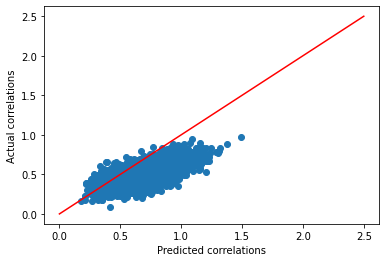

In [56]:
#W = model.model.get_loadings()
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist

W = model.model.decoder.weight.detach().cpu().numpy()
V = model.model.encoder.weight.detach().cpu().numpy()

estD = torch.exp(model.model.variational_logvars).detach().cpu().numpy()
est_sigma = (torch.exp(model.model.log_sigma_sq)).detach().cpu().numpy()

u, s, v = np.linalg.svd(V)
A = np.diag(s)

#A = np.diag(np.ones(V.shape[0])) * np.sqrt(est_sigma)

W = W @ A

d_estW = pdist(W)
dW = pdist(sims['W'])
# we appear to be off by a factor of 2 -- where is this coming from?
plt.scatter(dW, d_estW)
plt.plot(np.linspace(0, 2.5), np.linspace(0, 2.5), 'r')
plt.xlabel('Predicted correlations')
plt.ylabel('Actual correlations')

print(pearsonr(dW, d_estW))

In [15]:
s, np.sqrt(est_sigma)

(array([0.38749737, 0.37106648, 0.3380383 , 0.32340634, 0.29048142,
        0.27197507, 0.25999725, 0.2466552 , 0.23960088, 0.23436515],
       dtype=float32),
 0.5873347)

In [16]:
eigvals = (W**2).sum(axis=0)

np.sort(est_sigma / eigvals)

array([0.16958004, 0.18860108, 0.20949489, 0.2431334 , 0.2726347 ,
       0.32808805, 0.37252963, 0.4010957 , 0.43166828, 0.44552568],
      dtype=float32)

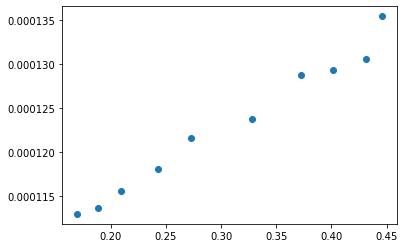

In [17]:
plt.scatter(np.sort(est_sigma / eigvals), np.sort(estD))

In [18]:
np.linalg.pinv(true_cov) @ est_cov

NameError: name 'true_cov' is not defined

In [19]:
np.diag(sims['W'].T @ sims['W'])

array([0.01      , 0.55333333, 1.09666667, 1.64      , 2.18333333,
       2.72666667, 3.27      , 3.81333333, 4.35666667, 4.9       ])

In [20]:
np.diag(W.T @ W)

array([2.0342135, 1.8290565, 1.646637 , 1.418818 , 1.2652901, 1.0514313,
       0.8600492, 0.9259989, 0.7742809, 0.7991369], dtype=float32)

In [21]:
eigvals = (W**2).sum(axis=0)
Weig = W / np.sqrt(eigvals)

In [22]:
np.round(Weig.T @ Weig, 2)

array([[ 1.  , -0.11,  0.1 , -0.09, -0.01, -0.09, -0.09,  0.03, -0.04,
         0.12],
       [-0.11,  1.  ,  0.01, -0.08, -0.01, -0.12,  0.1 , -0.13,  0.02,
         0.04],
       [ 0.1 ,  0.01,  1.  , -0.07, -0.01,  0.06,  0.03,  0.2 , -0.11,
         0.02],
       [-0.09, -0.08, -0.07,  1.  , -0.11,  0.12,  0.04,  0.08,  0.1 ,
        -0.04],
       [-0.01, -0.01, -0.01, -0.11,  1.  ,  0.15,  0.19, -0.08, -0.05,
        -0.07],
       [-0.09, -0.12,  0.06,  0.12,  0.15,  1.  , -0.05, -0.  ,  0.08,
        -0.09],
       [-0.09,  0.1 ,  0.03,  0.04,  0.19, -0.05,  1.  ,  0.15, -0.02,
         0.05],
       [ 0.03, -0.13,  0.2 ,  0.08, -0.08, -0.  ,  0.15,  1.  , -0.01,
         0.06],
       [-0.04,  0.02, -0.11,  0.1 , -0.05,  0.08, -0.02, -0.01,  1.  ,
         0.18],
       [ 0.12,  0.04,  0.02, -0.04, -0.07, -0.09,  0.05,  0.06,  0.18,
         1.  ]], dtype=float32)

In [23]:
Wu, Ws, Wv = np.linalg.svd(W)
k = W.shape[1]
Wu = Wu[:, :k]
Ws = Ws[:k]
Wv = Wv[:k, :]

In [24]:
np.linalg.norm(Weig.T @ Weig - np.eye(Weig.shape[-1]))

0.8651800123531395

In [25]:
Ws

array([1.5067155 , 1.3917949 , 1.2982903 , 1.2227132 , 1.1255814 ,
       1.0291264 , 0.9614367 , 0.87146944, 0.79033786, 0.7632519 ],
      dtype=float32)

In [26]:
eigvals = np.sqrt(np.sort(eigvals)[::-1])

In [27]:
np.sqrt(np.sum((eigvals - Ws)**2))

0.19167186

In [28]:
sims['sigma']

0.31622776601683794

In [29]:
torch.exp(model.model.log_sigma_sq)

tensor(0.3450, device='cuda:0', grad_fn=<ExpBackward>)

In [30]:
model.model.log_sigma_sq

Parameter containing:
tensor(-1.0643, device='cuda:0', requires_grad=True)

In [31]:
torch.sqrt(sims['sigma'] / torch.exp(model.model.log_sigma_sq))

tensor(0.9574, device='cuda:0', grad_fn=<SqrtBackward>)

In [32]:
est_sigma = (torch.exp(model.model.log_sigma_sq)).detach().cpu().numpy()
true_sigma = sims['sigma']

In [33]:
np.sort(sims['eigs'])[::-1]

array([5.        , 4.45666667, 3.91333333, 3.37      , 2.82666667,
       2.28333333, 1.74      , 1.19666667, 0.65333333, 0.11      ])

In [34]:
eigvals

array([1.4262586 , 1.3524262 , 1.2832135 , 1.1911415 , 1.1248511 ,
       1.0253932 , 0.9622884 , 0.92738837, 0.89394456, 0.87993234],
      dtype=float32)

In [35]:
np.sqrt(est_sigma), true_sigma

(0.5873347, 0.31622776601683794)